# From Images to a Place Memory: VPR Tutorial

```
This notebook demonstrates Visual Place Recognition (VPR) for robot localization using NetVLAD and a Vector Database.

SLAM provides precise motion tracking. VPR provides long-term place recognition. 
Combined, they enable reliable indoor localization over time.
```



---

# Part 0 — Setup & Init

In [1]:
# sys
import sys
import shutil
import time
import random
from pathlib import Path

# math
import numpy as np
import pandas as pd
import torch

# IO
import h5py
import yaml
from PIL import Image

# utils
from termcolor import colored
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Local modules
sys.path.insert(0, str(Path(".")))
from utils.vector_DB_IO import NetVLADMilvusDB
from vpr_core import extract_features, pairs_from_retrieval

# Check GPU availability
if torch.cuda.is_available():
    try:
        torch.cuda.current_device()
        torch.cuda.empty_cache()
        device = "cuda"
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    except RuntimeError as e:
        print(f"CUDA error: {e}")
        print("Falling back to CPU")
        device = "cpu"
else:
    device = "cpu"
    print("CUDA not available, using CPU")

print(f"Device: {device}")

GPU: NVIDIA GeForce RTX 4080 Laptop GPU
Device: cuda


In [2]:
# Data paths - Library B4 dataset
data_dir = Path("./data/library")
images_train = data_dir / "0407_0415_b4" / "0415_bobst_4_130509"  # Reference (April 15)
images_test = data_dir / "0625_0628_b4" / "0628_bobst4_144110"    # Query (June 28)
outputs = data_dir / "0415_0628_b4_outputs"
outputs.mkdir(exist_ok=True)

# Pose files
pose_file_train = data_dir / "0407_0415_b4" / "coordinate2.txt"  # 0415 is coordinate2
pose_file_test = data_dir / "0625_0628_b4" / "coordinate2.txt"   # 0628 is coordinate2

print(f"Reference images: {images_train.name} ({len(list(images_train.glob('*.jpg')))} files)")
print(f"Query images:     {images_test.name} ({len(list(images_test.glob('*.jpg')))} files)")
print(f"Outputs:          {outputs}")

Reference images: 0415_bobst_4_130509 (197 files)
Query images:     0628_bobst4_144110 (409 files)
Outputs:          data/library/0415_0628_b4_outputs


---

# Part 1 — Building Place Memory (Offline)

When the robot explores, we build a **place memory** by:
1. Converting each image into a compact **global descriptor** (place signature)
2. Storing these descriptors in a **vector database** with pose metadata from SLAM

This creates a searchable map of visual memories.

## Step 1 — Image → Place Signature (NetVLAD)

When a robot captures a frame, **NetVLAD** transforms it into a single vector using two key components:

### 1) CNN Backbone: Learning Visual Patterns
A convolutional neural network (e.g., VGG16) extracts **feature maps** — rich patterns related to:
- Shapes, Textures, Spatial layout

These features capture what the scene *looks and feels like*, beyond just raw pixels.

### 2) VLAD Layer: Compressing Features into a Vector
**VLAD** (Vector of Locally Aggregated Descriptors) clusters local features into visual concepts and measures:
- Which concepts are present
- How strongly they appear
- How they differ from learned "centers"

**Result:** A full image becomes a compact **4096-D vector** — a global descriptor representing the identity of a place.

In [3]:
# NetVLAD feature extraction config
feature_conf = {
    "model": {"name": "netvlad"},
    "output": "global-feats-netvlad",
    "preprocessing": {"resize_max": 1024},
}
print(colored(f"Feature config: {feature_conf}", "green"), flush=True)

# Output path for reference (train) features
feature_path_train = outputs / "global-feats-netvlad-train.h5"

# Set True to force re-extraction even if h5 file exists
FORCE_REEXTRACT = False

if FORCE_REEXTRACT:
    feature_path_train.unlink(missing_ok=True)
    print("Deleted existing feature file, will re-extract.", flush=True)

# Extract features for TRAIN set (reference images for place memory)
print("\n=== Extracting NetVLAD features for reference images ===", flush=True)
extract_features.main(feature_conf, images_train, outputs, feature_path=feature_path_train)
print(f"Reference features saved to: {feature_path_train}", flush=True)

Feature config: {'model': {'name': 'netvlad'}, 'output': 'global-feats-netvlad', 'preprocessing': {'resize_max': 1024}}

=== Extracting NetVLAD features for reference images ===


[2025/11/26 17:33:54 vpr_core INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2025/11/26 17:33:54 vpr_core INFO] Found 197 images in root data/library/0407_0415_b4/0415_bobst_4_130509.
[2025/11/26 17:33:54 vpr_core INFO] Skipping the extraction.


Reference features saved to: data/library/0415_0628_b4_outputs/global-feats-netvlad-train.h5


## Step 2 — Store Place Memories into Vector Database

Each NetVLAD vector becomes a **memory of a place**. To use it for localization, we also store **where the robot was**:
- Robot's pose (from SLAM system)
- Metadata: timestamp, image path, vertex ID

### Why a Vector Database?

A vector database provides:
- **Efficient long-term memory** for large environments
- **Real-time retrieval** even with millions of vectors
- **High-performance indexes** (IVF, HNSW) for fast similarity search

**In short:** A vector DB allows robots to remember more places, find memories faster, and use them intelligently.

### Match Pose with SLAM result (use real value later)

In [4]:
# Load ground-truth poses from coordinate file
poses_train = np.loadtxt(pose_file_train)  # (x, y) for reference session

print(f"Reference poses: {poses_train.shape}")

# Plot reference trajectory
# plt.figure(figsize=(8, 6))
# plt.scatter(poses_train[:, 0], poses_train[:, 1], c=np.arange(len(poses_train)), cmap='viridis', s=20)
# plt.colorbar(label='Image index')
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# plt.title('Reference Trajectory (0415 session)')
# plt.axis('equal')
# plt.grid(True, alpha=0.3)
# plt.show()

Reference poses: (197, 2)


In [5]:
# Load h5 features and insert into Milvus with pose metadata

# Initialize Milvus database
milvus_db_path = outputs / "milvus_netvlad.db"
db_manager = NetVLADMilvusDB(db_path=milvus_db_path, collection_name="place_memory")

# Get vector dimension from h5
with h5py.File(feature_path_train, 'r') as f:
    sample_desc = f[list(f.keys())[0]]['global_descriptor'][:]
    vector_dim = sample_desc.shape[0]
print(f"NetVLAD dimension: {vector_dim}")

# Create collection
db_manager.create_collection(dim=vector_dim, drop_old=True)

# Load h5 and insert row by row with real pose from coordinate file
print("\n=== Inserting features with pose metadata ===")
with h5py.File(feature_path_train, 'r') as f:
    image_names = list(f.keys())
    
    for i, img_name in enumerate(image_names):
        # Get descriptor (already normalized)
        desc = f[img_name]['global_descriptor'][:]
        
        # Parse image index from filename: "0.jpg" -> 0
        img_idx = int(Path(img_name).stem)
        
        # Get real pose from coordinate file
        pose_x, pose_y = poses_train[img_idx]
        
        # Insert row
        db_manager.insert_row(img_name, img_idx, pose_x, pose_y, desc)
        
        if (i + 1) % 50 == 0:
            print(f"  Inserted {i + 1}/{len(image_names)}")

# Load collection for search
db_manager.collection.load()
print(f"\n✓ Milvus ready with {len(image_names)} place memories")

✓ Connected to Milvus Lite at data/library/0415_0628_b4_outputs/milvus_netvlad.db
NetVLAD dimension: 4096
✓ Dropped existing collection: place_memory
✓ Created collection: place_memory
✓ Created index on descriptor field

=== Inserting features with pose metadata ===
  Inserted 50/197
  Inserted 100/197
  Inserted 150/197

✓ Milvus ready with 197 place memories


---

# Part 2 — Querying Place Memory (Online Localization)

Given the robot's current camera view, find where it might be on the map.

**Steps:**
1. Current View → Global Descriptor (NetVLAD)
2. KNN Search in Vector DB → retrieve similar places
3. Return candidate locations with similarity scores

In [6]:
# Load query poses and select test image
poses_test = np.loadtxt(pose_file_test)  # (x, y) for query session

test_image_path = images_test / "70.jpg"
query_idx = int(test_image_path.stem)
query_pose = poses_test[query_idx]
print(f"Query image: {test_image_path.name}")
print(f"Query ground-truth pose: ({query_pose[0]:.2f}, {query_pose[1]:.2f})\n")

total_start = time.time()

# Step 1: Copy image to temp directory
query_dir = outputs / "single_query"
query_dir.mkdir(exist_ok=True)
shutil.copy(test_image_path, query_dir / test_image_path.name)

# Step 2: Extract NetVLAD features (image → vector)
t2 = time.time()
query_h5_path = outputs / "single_query_features.h5"
if query_h5_path.exists():
    query_h5_path.unlink()

extract_features.main(feature_conf, query_dir, outputs, feature_path=query_h5_path)
print(colored(f"[1] NetVLAD extraction: {time.time() - t2:.3f}s", 'cyan'), flush=True)

# Step 3: Read the extracted vector
with h5py.File(query_h5_path, 'r') as f:
    img_name = list(f.keys())[0]
    query_vector = f[img_name]['global_descriptor'][:]
print(f"    Vector shape: {query_vector.shape}")

# Step 4: KNN Search in Milvus
t4 = time.time()
top_k = 5
matches = db_manager.search(query_vector, top_k=top_k)
print(colored(f"[2] Milvus search: {time.time() - t4:.3f}s", 'cyan'), flush=True)

# Display results
print(f"\n{'='*60}")
print(f"Query: {test_image_path.name} | GT pose: ({query_pose[0]:.2f}, {query_pose[1]:.2f})")
print(f"{'='*60}")
print(f"{'Rank':<6} {'Idx':<6} {'Pose (x, y)':<18} {'Similarity':<10} {'Image'}")
print(f"{'-'*60}")
for rank, (match_name, idx, pose_x, pose_y, similarity) in enumerate(matches, 1):
    print(f"{rank:<6} {idx:<6} ({pose_x:>7.2f}, {pose_y:>7.2f})   {similarity:<10.4f} {match_name}")
print(f"{'='*60}")
print(colored(f"Total query time: {time.time() - total_start:.3f}s", 'yellow'), flush=True)

# Cleanup temp files
shutil.rmtree(query_dir)
query_h5_path.unlink()

[2025/11/26 17:33:58 vpr_core INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2025/11/26 17:33:58 vpr_core INFO] Found 1 images in root data/library/0415_0628_b4_outputs/single_query.


Query image: 70.jpg
Query ground-truth pose: (2.78, 35.24)

    ├─ Dataset prep: 0.001s
    ├─ Model loading: 4.437s


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
[2025/11/26 17:34:03 vpr_core INFO] Finished exporting features.


    ├─ Inference: 0.229s
    ├─ H5 writing: 0.002s
    └─ Total extract_features.main: 4.758s
[1] NetVLAD extraction: 4.759s
    Vector shape: (4096,)
[2] Milvus search: 0.003s

Query: 70.jpg | GT pose: (2.78, 35.24)
Rank   Idx    Pose (x, y)        Similarity Image
------------------------------------------------------------
1      134    ( -21.56,   -9.13)   0.5594     134.jpg
2      143    ( -21.23,   -8.91)   0.5560     143.jpg
3      136    ( -21.54,   -9.88)   0.5544     136.jpg
4      191    ( -22.15,    8.82)   0.5309     191.jpg
5      193    ( -22.18,    9.56)   0.5149     193.jpg
Total query time: 4.764s


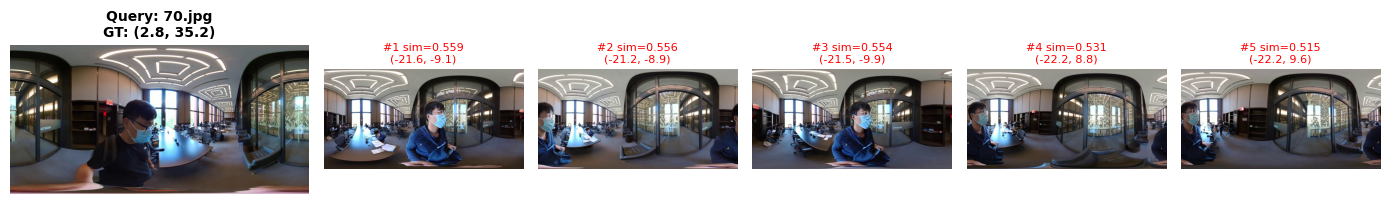

In [7]:
# Visualize query results
SIM_THRESHOLD = 0.7      # Below this = low confidence (red)
DROP_THRESHOLD = 0.05    # Sudden drop from previous = unreliable (red)

fig = plt.figure(figsize=(14, 6))
gs = GridSpec(1, top_k + 1, width_ratios=[1.5] + [1]*top_k)

# Query image (left)
ax_query = fig.add_subplot(gs[0, 0])
query_img = Image.open(test_image_path)
ax_query.imshow(query_img)
ax_query.set_title(f"Query: {test_image_path.name}\nGT: ({query_pose[0]:.1f}, {query_pose[1]:.1f})", fontsize=10, fontweight='bold')
ax_query.axis('off')

# Top-K matches (right)
prev_sim = None
for i, (match_name, idx, pose_x, pose_y, similarity) in enumerate(matches):
    ax = fig.add_subplot(gs[0, i + 1])
    match_path = images_train / match_name
    if match_path.exists():
        match_img = Image.open(match_path)
        ax.imshow(match_img)
    
    # Check for low similarity or sudden drop
    is_low = similarity < SIM_THRESHOLD
    is_drop = prev_sim is not None and (prev_sim - similarity) > DROP_THRESHOLD
    title_color = 'red' if (is_low or is_drop) else 'green'
    
    ax.set_title(f"#{i+1} sim={similarity:.3f}\n({pose_x:.1f}, {pose_y:.1f})", fontsize=8, color=title_color)
    ax.axis('off')
    prev_sim = similarity

plt.tight_layout()
plt.show()

---

# Part 3 — (Optional) Multi-Frame Aggregation

Even with strong descriptors like NetVLAD, a single frame may not always be reliable — especially in environments with **repetitive structures** (corridors) or **motion blur**.

## Strategy: Use Multiple Recent Frames

Instead of trusting a single frame, use the **last N frames** (e.g., 3-5 images):
1. Perform VPR search for each frame (top-K results)
2. Aggregate all candidate matches
3. Find consensus among observations

## Aggregation Methods

**Method A — Frequency Clustering**  
Count how many times each candidate location appears across all frames. More consistent results → more likely correct.

**Method B — Spatial Voting**  
Each candidate has a known pose → group nearby poses on the map. The largest cluster → best location estimate.

**Method C — Heatmap Filtering**  
Plot match scores onto the map → regions with higher accumulated scores → more confident hypothesis.

## Why This Helps

Indoor motion is usually **continuous and smooth**. If frame 1 says "corridor A" but frames 2-5 say "lobby area", the system can confidently discard the outlier.

**With only lightweight post-processing, VPR accuracy and robustness improve significantly.**




In [8]:
pass

---

# Summary

In this tutorial, we built a complete VPR-based localization system:

1. **NetVLAD** converts camera frames into global descriptors (place signatures)
2. **Vector Database** stores these descriptors with pose metadata from SLAM
3. **Online Query** retrieves the most similar places for coarse localization
4. **(Optional) Multi-frame aggregation** improves reliability

**SLAM provides precise motion tracking. VPR provides long-term place recognition.**  
Combined, they enable reliable indoor localization over time.